In [1]:
import os
import torch, torchvision
from torchvision import transforms
from collections import Counter
from tqdm import tqdm
from PIL import Image
import PIL
from matplotlib import pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
!pip install torchinfo
from torchinfo import summary
import torch.nn as nn

In [2]:
# Загружаем датасет

import kagglehub

path = kagglehub.dataset_download("maysee/mushrooms-classification-common-genuss-images")
data_path = os.path.join(path, 'Mushrooms')
print("Path to dataset images:", data_path)

Path to dataset images: /kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms


In [3]:
# определяем трансформации, применяемые к изображениям

class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5
    return mean, std

# mean и std были посчитаны при помощи функции get_mean_std заранее
mean = [0.3914, 0.3697, 0.2814]
std = [0.2499, 0.2269, 0.2237]
transform = transforms.Compose([
    ConvertToRGB(),
    transforms.CenterCrop((448, 448)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
dataset = torchvision.datasets.ImageFolder(data_path, transform=transform)

Изображение с индексом 5407 вызывает ошибку:

In [5]:
# dataset[5407] - ошибка!

In [6]:
# удаляем из dataset изображение с индексом 5407
dataset.samples = [(path, target) for path, target in dataset.samples if path != dataset.samples[5407][0]]

In [7]:
# подсчет распределения классов в dataset
counts = Counter(x[1] for x in tqdm(dataset))
class_distribution = {cat: counts[i] for cat, i in dataset.class_to_idx.items()}
print(class_distribution)

100%|██████████| 6713/6713 [00:52<00:00, 127.80it/s]

{'Agaricus': 353, 'Amanita': 750, 'Boletus': 1073, 'Cortinarius': 836, 'Entoloma': 364, 'Hygrocybe': 316, 'Lactarius': 1563, 'Russula': 1147, 'Suillus': 311}


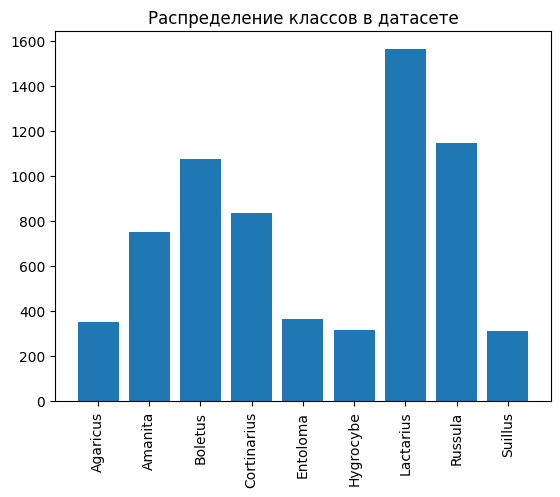

In [8]:
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title("Распределение классов в датасете")
plt.xticks(rotation=90)
plt.show()

In [9]:
from torch.utils.data import random_split

g = torch.Generator()
g.manual_seed(42)

# разделяем данные на тренировочную, валидационную и тестовую выборки
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.75, 0.1, 0.15], g)
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

5035
672
1006


In [10]:
# функция подсчета классов
def class_counts(dataset) -> pd.Series:
    c = Counter(x[1] for x in tqdm(dataset))
    class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

100%|██████████| 5035/5035 [00:35<00:00, 143.20it/s]


<Axes: title={'center': 'распределение классов в тренировочной выборке'}>

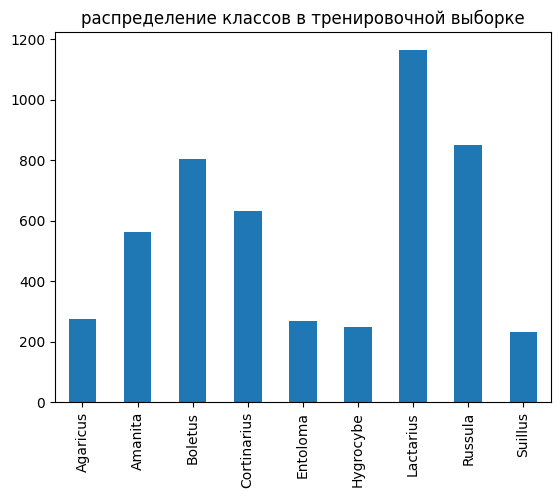

In [11]:
(class_counts(train_dataset)).plot(kind='bar', title="распределение классов в тренировочной выборке")

100%|██████████| 672/672 [00:04<00:00, 157.97it/s]


<Axes: title={'center': 'распределение классов в валидационноый выборке'}>

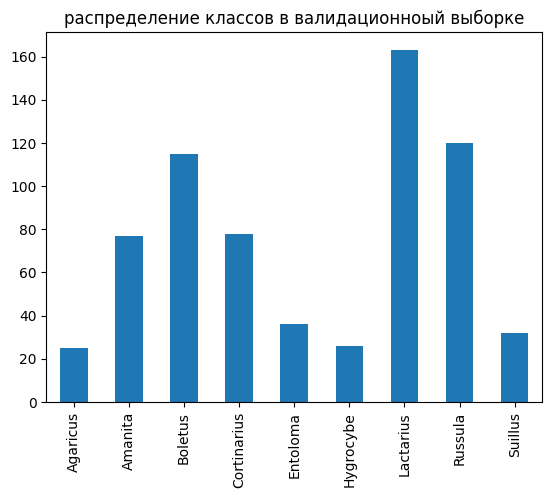

In [12]:
(class_counts(val_dataset)).plot(kind='bar', title="распределение классов в валидационноый выборке")

100%|██████████| 1006/1006 [00:07<00:00, 140.67it/s]


<Axes: title={'center': 'распределение классов в тестовой выборке'}>

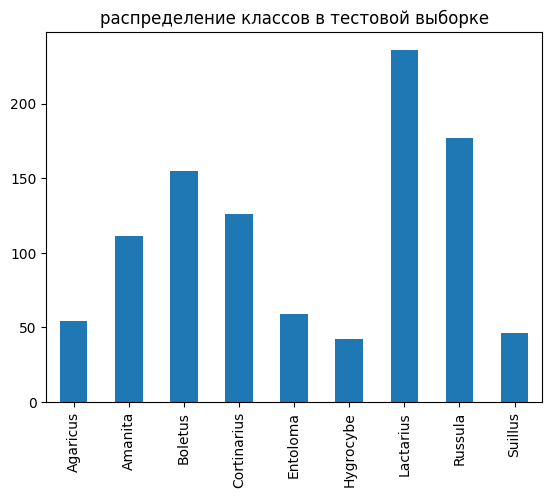

In [13]:
(class_counts(test_dataset)).plot(kind='bar', title="распределение классов в тестовой выборке")

In [14]:
# загрузчики

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [15]:
# функции, используемые для обучения и оценки точности модели

def train_epoch(model, optimizer, loss_fn, data_loader, device="cpu"):
    training_loss = 0.0
    model.train()

    for inputs, targets in tqdm(data_loader, desc="Training", leave=False):
        optimizer.zero_grad()

        inputs = inputs.to(device)
        targets = targets.to(device)

        output = model(inputs)
        loss = loss_fn(output, targets)

        loss.backward()
        optimizer.step()
        training_loss += loss.data.item() * inputs.size(0)

    return training_loss / len(data_loader.dataset)


def score(model, data_loader, loss_fn, device="cpu"):
    model.eval()

    total_loss = 0
    total_correct = 0

    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Scoring", leave=False):
            inputs = inputs.to(device)
            targets = targets.to(device)

            output = model(inputs)
            loss = loss_fn(output, targets)
            total_loss += loss.data.item() * inputs.size(0)

            correct = torch.eq(torch.argmax(output, dim=1), targets)
            total_correct += torch.sum(correct).item()

    return total_loss / len(data_loader.dataset), total_correct / len(
        data_loader.dataset
    )


def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):

    for epoch in range(1, epochs + 1):
        training_loss = train_epoch(model, optimizer, loss_fn, train_loader, device)
        validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)

        print(
            f"Epoch: {epoch}, Training Loss: {training_loss:.2f}, "
            f"Validation Loss: {validation_loss:.2f}, Validation Accuracy: {validation_accuracy:.2f}"
        )

В качестве используемой модели выбираем предобученную сверточную сеть Alexnet:

In [16]:
import torchvision.models as models
alexnet = models.alexnet(pretrained=True)

# Заменяем весь классифицирующий слой
alexnet.classifier = nn.Sequential(
    nn.Dropout(),
    nn.Linear(256 * 6 * 6, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096, 9)
)

# замораживаем остальные слои
for param in alexnet.features.parameters():
    param.requires_grad = False

summary(alexnet)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Param #
AlexNet                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       (23,296)
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       (307,392)
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
│    └─Conv2d: 2-7                       (663,936)
│    └─ReLU: 2-8                         --
│    └─Conv2d: 2-9                       (884,992)
│    └─ReLU: 2-10                        --
│    └─Conv2d: 2-11                      (590,080)
│    └─ReLU: 2-12                        --
│    └─MaxPool2d: 2-13                   --
├─AdaptiveAvgPool2d: 1-2                 --
├─Sequential: 1-3                        --
│    └─Dropout: 2-14                     --
│    └─Linear: 2-15                      37,752,832
│    └─ReLU: 2-16                        --
│    └─Dropout: 2-17         

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet.to(device)

# выбираем функцию потерь и оптимизатор
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alexnet.classifier.parameters(), lr=0.001)

In [18]:
# обучаем модель 30 эпох
train(alexnet, optimizer, loss_fn, train_loader, val_loader, epochs=30, device=device)

Epoch: 1, Training Loss: 2.36, Validation Loss: 1.37, Validation Accuracy: 0.54


Epoch: 2, Training Loss: 1.42, Validation Loss: 1.30, Validation Accuracy: 0.56


Epoch: 3, Training Loss: 1.32, Validation Loss: 1.29, Validation Accuracy: 0.59


Epoch: 4, Training Loss: 1.21, Validation Loss: 1.20, Validation Accuracy: 0.59


Epoch: 5, Training Loss: 1.16, Validation Loss: 1.20, Validation Accuracy: 0.63


Epoch: 6, Training Loss: 1.10, Validation Loss: 1.19, Validation Accuracy: 0.63


Epoch: 7, Training Loss: 1.03, Validation Loss: 1.14, Validation Accuracy: 0.65


Epoch: 8, Training Loss: 0.99, Validation Loss: 1.07, Validation Accuracy: 0.65


Epoch: 9, Training Loss: 0.95, Validation Loss: 1.08, Validation Accuracy: 0.64


Epoch: 10, Training Loss: 0.94, Validation Loss: 1.09, Validation Accuracy: 0.64


Epoch: 11, Training Loss: 0.88, Validation Loss: 1.10, Validation Accuracy: 0.64


Epoch: 12, Training Loss: 0.85, Validation Loss: 1.10, Validation Accuracy: 0.64


Epoch: 13, Training Loss: 0.83, Validation Loss: 1.03, Validation Accuracy: 0.67


Epoch: 14, Training Loss: 0.79, Validation Loss: 1.10, Validation Accuracy: 0.68


Epoch: 15, Training Loss: 0.79, Validation Loss: 1.08, Validation Accuracy: 0.67


Epoch: 16, Training Loss: 0.75, Validation Loss: 1.02, Validation Accuracy: 0.68


Epoch: 17, Training Loss: 0.74, Validation Loss: 1.06, Validation Accuracy: 0.67


Epoch: 18, Training Loss: 0.73, Validation Loss: 1.07, Validation Accuracy: 0.66


Epoch: 19, Training Loss: 0.70, Validation Loss: 1.11, Validation Accuracy: 0.63


Epoch: 20, Training Loss: 0.67, Validation Loss: 1.03, Validation Accuracy: 0.67


Epoch: 21, Training Loss: 0.72, Validation Loss: 1.11, Validation Accuracy: 0.65


Epoch: 22, Training Loss: 0.66, Validation Loss: 1.08, Validation Accuracy: 0.65


Epoch: 23, Training Loss: 0.63, Validation Loss: 1.07, Validation Accuracy: 0.66


Epoch: 24, Training Loss: 0.66, Validation Loss: 1.09, Validation Accuracy: 0.65


Epoch: 25, Training Loss: 0.67, Validation Loss: 1.11, Validation Accuracy: 0.67


Epoch: 26, Training Loss: 0.69, Validation Loss: 1.07, Validation Accuracy: 0.68


Epoch: 27, Training Loss: 0.63, Validation Loss: 1.06, Validation Accuracy: 0.67


Epoch: 28, Training Loss: 0.61, Validation Loss: 1.07, Validation Accuracy: 0.65


Epoch: 29, Training Loss: 0.64, Validation Loss: 1.12, Validation Accuracy: 0.65


Epoch: 30, Training Loss: 0.60, Validation Loss: 1.06, Validation Accuracy: 0.68


In [23]:
# обучаем модель еще 5 эпох
train(alexnet, optimizer, loss_fn, train_loader, val_loader, epochs=5, device=device)

Epoch: 1, Training Loss: 0.61, Validation Loss: 1.06, Validation Accuracy: 0.68


Epoch: 2, Training Loss: 0.56, Validation Loss: 1.07, Validation Accuracy: 0.66


Epoch: 3, Training Loss: 0.53, Validation Loss: 1.08, Validation Accuracy: 0.67


Epoch: 4, Training Loss: 0.55, Validation Loss: 1.08, Validation Accuracy: 0.65


Epoch: 5, Training Loss: 0.55, Validation Loss: 1.06, Validation Accuracy: 0.67


In [19]:
# оцениваем точность модели на тестовой выборке

test_loss, test_accuracy = score(alexnet, test_loader, loss_fn, device)
print(f"Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}")

Test Loss: 1.03, Test Accuracy: 0.68


In [20]:
# сохраняем модель
torch.save(alexnet.state_dict(), 'model.pth')

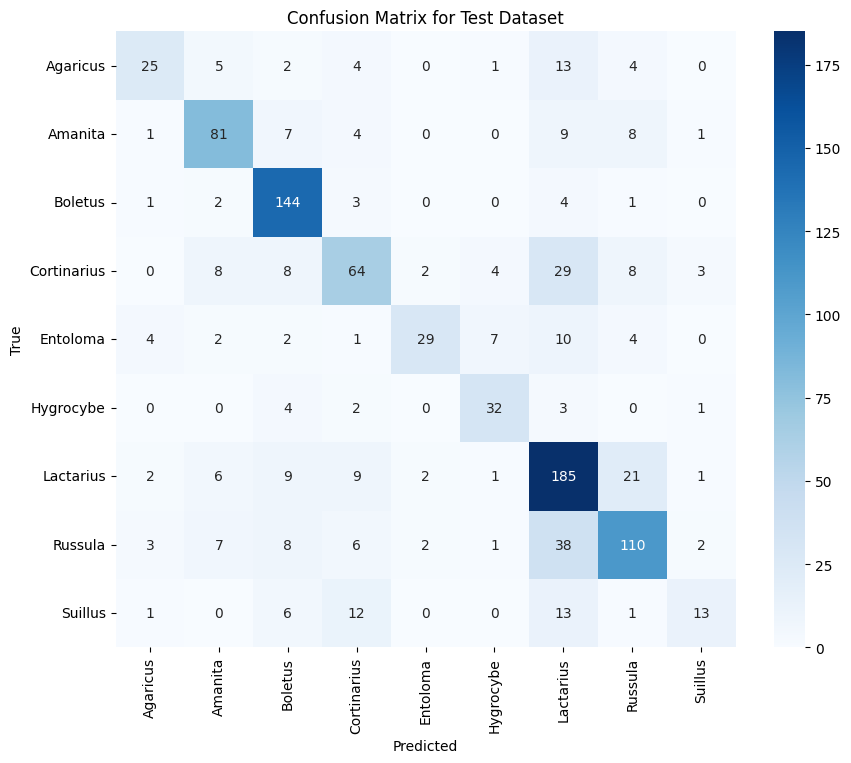

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Get predictions and true labels for the test set
all_preds = []
all_targets = []
with torch.no_grad():
    for inputs, targets in tqdm(test_loader, desc="Generating Confusion Matrix", leave=False):
        inputs = inputs.to(device)
        outputs = alexnet(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Get class names
class_names = dataset.classes

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Test Dataset')
plt.show()

Лучшая точность, которой удалось добиться на тестовой выборке составляет 68%